# Import Library

In [282]:
!pip install pmdarima
!pip install statsmodels

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer
from itertools import product

# Import Data

In [284]:
df_customer = pd.read_csv('customer.csv', sep= ';')
df_product = pd.read_csv('product.csv', sep= ';')
df_store = pd.read_csv('store.csv', sep= ';')
df_transaction = pd.read_csv('transaction.csv', sep= ';')

# Data Preparation

In [285]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [286]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [287]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [288]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [289]:
df1 = pd.merge(df_transaction, df_customer, on='CustomerID', how='inner')
df2 = pd.merge(df1, df_store, on = 'StoreID', how = 'inner')
df_final = pd.merge(df2, df_product, on = 'ProductID', how = 'inner')
df_final.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [290]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

In [291]:
(df_final['Price_x']/df_final['Price_y']).value_counts()

1.0    5020
dtype: int64

Kolom Price_x dan Price_y memiliki nilai yang sama pada setiap kolomnya sehingga dapat didrop salah satunya

In [292]:
df_final.drop(columns ='Price_y', inplace = True)

In [293]:
df_final.isna().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
dtype: int64

In [294]:
df_final.duplicated().sum()

0

In [295]:
#drop missing values karena tidak signifikan jumlahnya
df_final.dropna(inplace = True)
df_final.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Product Name      0
dtype: int64

In [296]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   4976 non-null   object
 1   CustomerID      4976 non-null   int64 
 2   Date            4976 non-null   object
 3   ProductID       4976 non-null   object
 4   Price_x         4976 non-null   int64 
 5   Qty             4976 non-null   int64 
 6   TotalAmount     4976 non-null   int64 
 7   StoreID         4976 non-null   int64 
 8   Age             4976 non-null   int64 
 9   Gender          4976 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          4976 non-null   object
 12  StoreName       4976 non-null   object
 13  GroupStore      4976 non-null   object
 14  Type            4976 non-null   object
 15  Latitude        4976 non-null   object
 16  Longitude       4976 non-null   object
 17  Product Name    4976 non-null   object
dtypes: int64

In [297]:
df_final.Date

0       01/01/2022
1       17/07/2022
2       26/09/2022
3       08/01/2022
4       10/01/2022
           ...    
5015    14/07/2022
5016    03/09/2022
5017    08/03/2022
5018    07/07/2022
5019    22/05/2022
Name: Date, Length: 4976, dtype: object

### Change Data Type of Irrelevant Data Types

In [298]:
df_final['Date'] = pd.to_datetime(df_final['Date'], format='%d/%m/%Y')
df_final['Longitude'] = df_final['Longitude'].apply(lambda x: x.replace(',','.')).astype(float)
df_final['Latitude'] = df_final['Latitude'].apply(lambda x: x.replace(',','.')).astype(float)

In [299]:
df_final.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers


In [300]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4976 non-null   object        
 1   CustomerID      4976 non-null   int64         
 2   Date            4976 non-null   datetime64[ns]
 3   ProductID       4976 non-null   object        
 4   Price_x         4976 non-null   int64         
 5   Qty             4976 non-null   int64         
 6   TotalAmount     4976 non-null   int64         
 7   StoreID         4976 non-null   int64         
 8   Age             4976 non-null   int64         
 9   Gender          4976 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          4976 non-null   object        
 12  StoreName       4976 non-null   object        
 13  GroupStore      4976 non-null   object        
 14  Type            4976 non-null   object        
 15  Lati

# Time Series Regression Analysis

<Axes: xlabel='Date'>

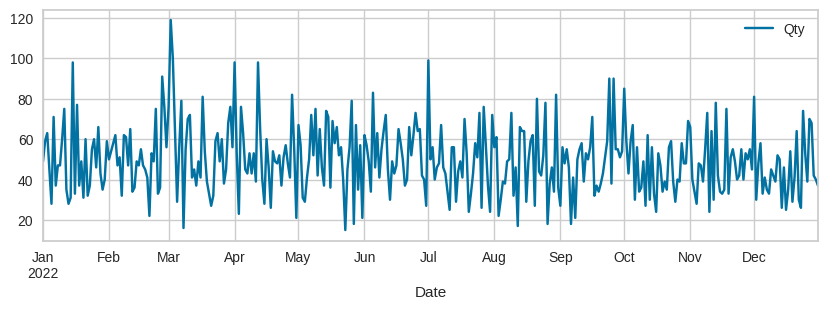

In [301]:
# Visualize Data
df_regression = df_final.groupby('Date').agg({'Qty':'sum'})
df_regression.plot(figsize=(10,3))

In [302]:
#Split Data Train & Data Test
print(df_regression.shape)
test_size = round(df_regression.shape[0] * 0.15)
train=df_regression.iloc[:-1*(test_size)]
test=df_regression.iloc[-1*(test_size):]
print(train.shape,test.shape)

(365, 1)
(310, 1) (55, 1)


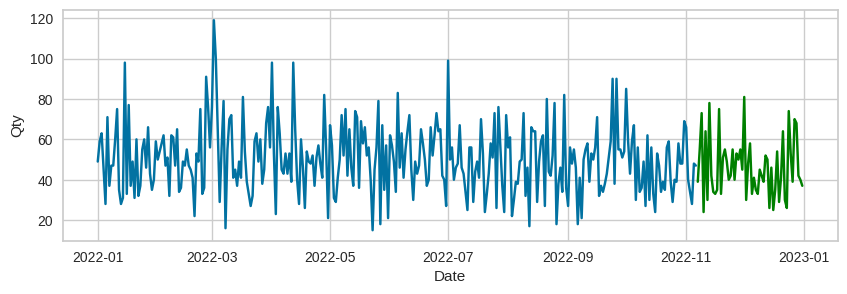

In [303]:
plt.figure(figsize=(10,3))
sns.lineplot(data=train, x=train.index, y=train['Qty'])
sns.lineplot(data=test, color="green", x=test.index, y=test['Qty'])
plt.show()

## Data Stationary Check

In [304]:
def adf_test(dataset):
     df_test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df_test[0])
     print("2. P-Value : ", df_test[1])
     print("3. Num Of Lags : ", df_test[2])
     print("4. Num Of Observations Used For ADF Regression:", df_test[3])
     print("5. Critical Values :")
     for key, val in df_test[4].items():
         print("\t",key, ": ", val)
adf_test(df_regression)

1. ADF :  -19.24830156679947
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


###### P-Value < 0.05 shows that the data is stationary and can be used in time series analysis with ARIMA

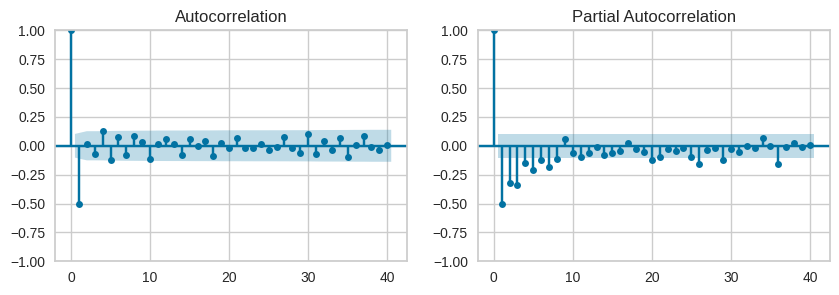

In [305]:
# ACF and PACF plots to determine p and q values
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(df_regression.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_regression.diff().dropna(), lags=40, ax=ax[1])
plt.show()

###### The Autocorrelation graph (ACF) shows that the p order is 2 because the first and second lag is significantly out of the significant limit, <br> meanwhile the Partial Autocorrelation graph (PCF) shows that the q order is 3 due to the significant correlation of the first until third lag.

## Modelling

### Auto-fit ARIMA

In [306]:
#auto-fit ARIMA
af_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
af_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Hyperparameter Tuning

In [307]:
# Make p, d, q list
p = range(0, 4)  # 0-3
d = range(0, 4)  # 0-3
q = range(0, 4)  # 0-3
# make p, d, dan q combination using product function
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3)]


In [308]:
# Make list to store AIC scores
aic_scores = []
# find the optimal p, d, q
for param in pdq:
    # Melakukan fitting ARIMA model
    model = ARIMA(df_regression, order=param)
    model_fit = model.fit()
    # Menambahkan aic score ke list
    aic_scores.append({'par': param, 'aic': model_fit.aic})

# Memilih aic score terkecil
best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (0, 1, 1), 'aic': 3090.7666642019835}


In [309]:
#Hyperparameter tuning
model_ht = ARIMA(train, order=best_aic['par'])
model_fit_ht = model_ht.fit()

###  Manual Hyperparameter Tuning

In [310]:
#Trial and error tuning
model_manualHt = ARIMA(train, order=(40,2,2))
model_fit_manualHt = model_manualHt.fit()

### Plot Forecasting

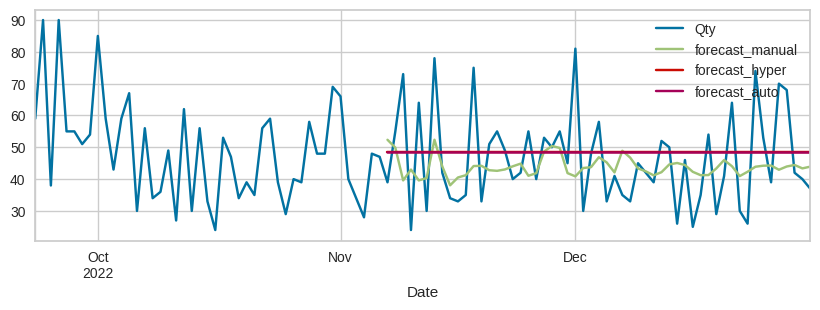

In [311]:
#plot forecasting
forecast_manualHt = model_fit_manualHt.forecast(len(test))
forecast_ht = model_fit_ht.forecast(len(test))
forecast_af = af_arima.predict(len(test))

df_plot = df_regression.iloc[-100:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(forecast_manualHt)) + list(forecast_manualHt)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_ht)) + list(forecast_ht)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_af)) + list(forecast_af)

df_plot.plot(figsize=(10, 3))
plt.show()

### Metrics Evaluation

In [312]:
#Manual parameter tuning metrics

mae = mean_absolute_error(test, forecast_manualHt)
mape = mean_absolute_percentage_error(test, forecast_manualHt)
rmse = np.sqrt(mean_squared_error(test, forecast_manualHt))

print(f'Mean Absolute Error - manual            : {round(mae,4)}')
print(f'Mean Absolute Percentage Error - manual : {round(mape,4)}')
print(f'Root Mean Square Error - manual         : {round(rmse,4)}')

Mean Absolute Error - manual            : 11.2065
Mean Absolute Percentage Error - manual : 0.2491
Root Mean Square Error - manual         : 14.5473


In [313]:
#Hyperparameter tuning metrics

mae = mean_absolute_error(test, forecast_ht)
mape = mean_absolute_percentage_error(test, forecast_ht)
rmse = np.sqrt(mean_squared_error(test, forecast_ht))

print(f'Mean Absolute Error - hyper            : {round(mae,4)}')
print(f'Mean Absolute Percentage Error - hyper : {round(mape,4)}')
print(f'Root Mean Square Error - hyper         : {round(rmse,4)}')

Mean Absolute Error - hyper            : 12.1944
Mean Absolute Percentage Error - hyper : 0.3001
Root Mean Square Error - hyper         : 14.6217


In [314]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(test, forecast_af)
mape = mean_absolute_percentage_error(test, forecast_af)
rmse = np.sqrt(mean_squared_error(test, forecast_af))

print(f'Mean Absolute Error - auto            : {round(mae,4)}')
print(f'Mean Absolute Percentage Error - auto : {round(mape,4)}')
print(f'Root Mean Square Error - auto         : {round(rmse,4)}')

Mean Absolute Error - auto            : 12.1807
Mean Absolute Percentage Error - auto : 0.2994
Root Mean Square Error - auto         : 14.6111


###### Manual Hyperparameter Tuning with order (40,2,2) shows the best evaluation metrics.

## Forecast Quantity Sales with The Best Parameter

In [315]:
#Apply model to forecast data
model = ARIMA(df_regression, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [316]:
df_regression

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


In [317]:
forecast

2023-01-01    48.032620
2023-01-02    52.771970
2023-01-03    42.415548
2023-01-04    42.371087
2023-01-05    48.184608
2023-01-06    42.588385
2023-01-07    41.250563
2023-01-08    42.012141
2023-01-09    47.379681
2023-01-10    47.040452
2023-01-11    39.379183
2023-01-12    38.310967
2023-01-13    39.579069
2023-01-14    43.966695
2023-01-15    35.687121
2023-01-16    42.231282
2023-01-17    47.299585
2023-01-18    44.852787
2023-01-19    40.623193
2023-01-20    46.828698
2023-01-21    43.228274
2023-01-22    39.244635
2023-01-23    50.856941
2023-01-24    51.581725
2023-01-25    41.013727
2023-01-26    47.031478
2023-01-27    50.280388
2023-01-28    41.314691
2023-01-29    42.729599
2023-01-30    49.428432
2023-01-31    45.003954
Freq: D, Name: predicted_mean, dtype: float64

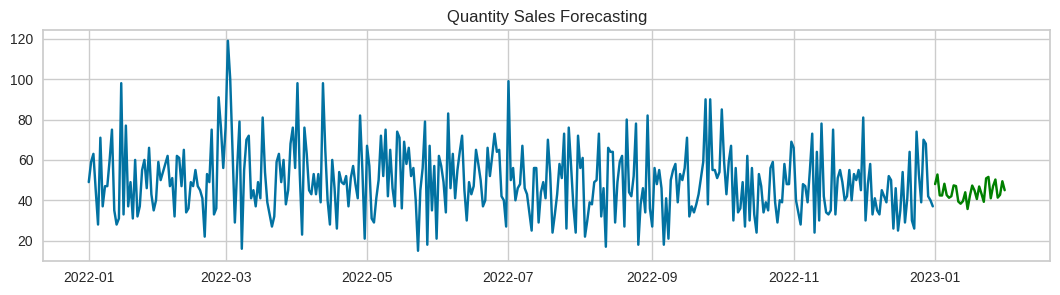

In [318]:
#Plot forecasting
plt.figure(figsize=(13,3))
plt.plot(df_regression)
plt.plot(forecast,color='green')
plt.title('Quantity Sales Forecasting')
plt.show()

In [319]:
forecast.describe()

count    31.000000
mean     44.339338
std       4.272234
min      35.687121
25%      41.282627
50%      43.228274
75%      47.339633
max      52.771970
Name: predicted_mean, dtype: float64

##### **From the forecast, the average quantity sales in January 2023 is 44.339338 or up rounded to around 44 pcs/day.**

# Clustering

In [320]:
df_final.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers


In [321]:
df_precluster = df_final.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_precluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


In [322]:
df_precluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     444 non-null    int64
 1   TransactionID  444 non-null    int64
 2   Qty            444 non-null    int64
 3   TotalAmount    444 non-null    int64
dtypes: int64(4)
memory usage: 14.0 KB


In [323]:
df_cluster = df_precluster.drop(columns = ['CustomerID'])
df_cluster.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [324]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TransactionID  444 non-null    int64
 1   Qty            444 non-null    int64
 2   TotalAmount    444 non-null    int64
dtypes: int64(3)
memory usage: 10.5 KB


In [325]:
df_cluster.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [326]:
#Standarisasi dataset
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [327]:
#Normalisasi dataset dengan minmaxscaler
X_norm = MinMaxScaler().fit_transform(X)
X_norm

array([[0.77777778, 0.72463768, 0.70394911],
       [0.55555556, 0.68115942, 0.39782666],
       [0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.83333333, 0.84057971, 0.6561092 ],
       [0.44444444, 0.46376812, 0.43890803],
       [0.55555556, 0.46376812, 0.46011132]])

In [328]:
# Normalisasi dataset dengan preprocessing sklearn
X_norm2 = preprocessing.normalize(df_cluster)
X_norm2

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [329]:
X_std

array([[ 1.78828224,  1.50893374,  2.10242393],
       [ 0.55344971,  1.27289149,  0.24634281],
       [ 1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 2.09699037,  2.13837973,  1.81236104],
       [-0.06396655,  0.09268025,  0.49542729],
       [ 0.55344971,  0.09268025,  0.62398702]])

In [330]:
df_std

,TransactionID,Qty,TotalAmount
0,1.788282,1.508934,2.102424
1,0.553450,1.272891,0.246343
2,1.170866,1.194211,0.679428
3,-0.372675,0.407403,-0.475199
4,-1.298799,-1.087531,-0.747585
...,...,...,...
439,0.553450,-0.300723,-0.741157
440,2.096990,1.666295,1.736029
441,2.096990,2.138380,1.812361
442,-0.063967,0.092680,0.495427


In [331]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1332.0000000000005, 543.4711248616254, 316.54668247055474, 237.60472575971139, 191.11956602309158, 169.32473141353285, 154.03936160517267, 142.48512585227888, 130.90829014139524, 121.69651564034504]


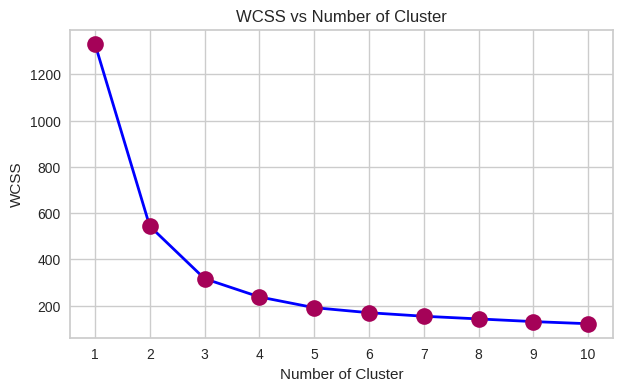

In [332]:
plt.figure(figsize=(7,4))
plt.plot(list(range(1,11)), wcss, color = 'blue', marker = 'o', linewidth=2, markersize=12, markerfacecolor= 'm',
         markeredgecolor= 'm')
plt.title('WCSS vs Number of Cluster')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

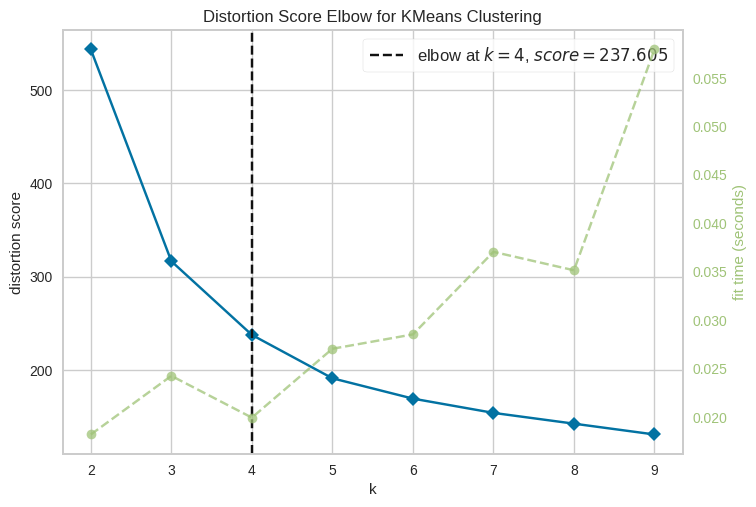

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [333]:
#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [334]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

<Axes: >

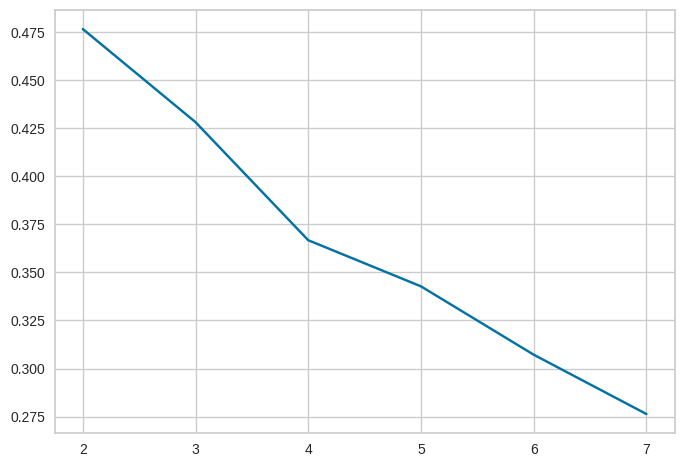

In [335]:
sns.lineplot(x = K, y = score)

### Cluster terbaik (k) terdapat pada 4 cluster

In [336]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [337]:
# Masukin cluster ke dataset
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,0
1,13,57,392300,2
2,15,56,446200,2
3,10,46,302500,3
4,7,27,268600,1


<Figure size 600x600 with 0 Axes>

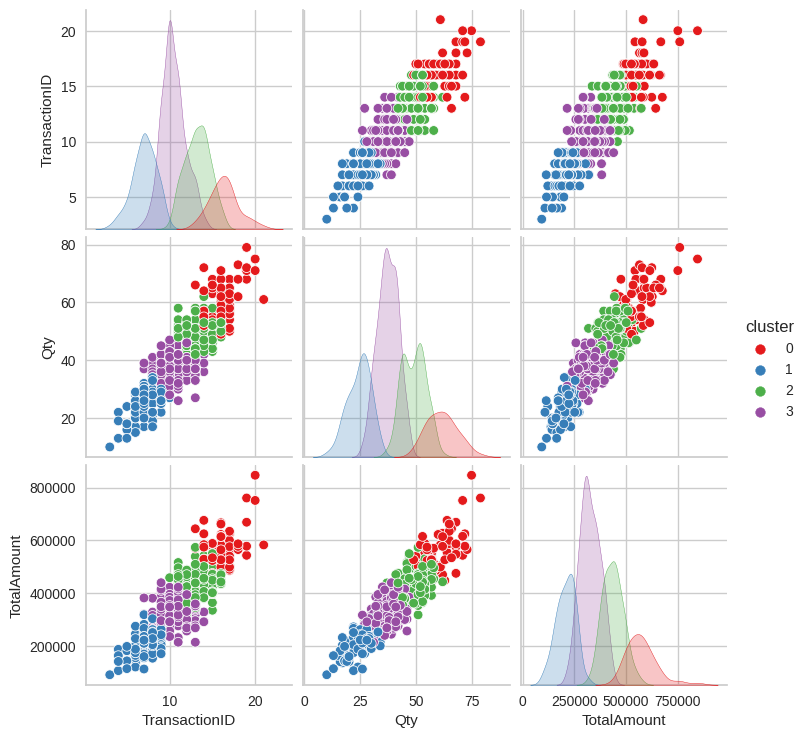

In [338]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set1')
plt.show()

In [339]:
df_cluster['CustomerID'] = df_precluster['CustomerID']
df_cluster_mean = df_cluster.groupby('cluster').agg({'CustomerID':'count','TransactionID':'mean','Qty':'mean','TotalAmount':'mean'})
df_cluster_mean.sort_values('CustomerID', ascending = False)

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
3,180,10.427778,37.350000,325663.333333
2,113,13.247788,49.070796,435833.628319
1,93,7.021505,24.505376,208283.870968
0,58,16.362069,61.689655,574650.000000


### **Summary**
Notes: Karakteristik metrik: transaksi, kuantitas, total jumlah
<br>
* **Cluster 0** <br>
    Kluster ini memiliki jumlah pelanggan paling sedikit. Pelanggan dalam kelompok ini memiliki karakteristik yang menduduki peringkat tertinggi dalam setiap metrik.
 <br> **Rekomendasi**:
  1. Menawarkan program loyalitas (poin) untuk mempertahankan tingkat transaksi.
  2. Melakukan survei kepuasan pelanggan.
  3. Membuat produk atau paket premium dengan harga yang lebih tinggi
  4. Menawarkan program afiliasi yang tersedia untuk semua orang

* **Cluster 1** <br>
    Kluster ini terdiri dari pelanggan dengan peringkat terendah dalam setiap metrik.
<br> **Rekomendasi**:
  1. Menawarkan Bundling Produk atau Penawaran Diskon Volume
  2. Melakukan survei untuk mengidentifikasi potensi pengembangan produk.
  3. Menyiapkan tim dukungan pelanggan yang responsif dan berpengetahuan untuk membantu pelanggan dengan pertanyaan atau masalah yang mereka alami.
  4. Membuat section FAQ secara online, artikel tutorial, atau forum komunitas tempat pelanggan dapat berinteraksi dan saling berbagi informasi.
  
* **Cluster 2** <br>
    Pelanggan dalam kelompok ini memiliki karakteristik yang menduduki peringkat kedua tertinggi dalam setiap metrik.
<br> **Rekomendasi**:
    1. Fokus melakukan up-selling
    2. Mengadakan program loyalitas
    3. Mengadakan umpan balik secara teratur dari pelanggan untuk memahami kebutuhan dan preferensi mereka.

* **Cluster 3** <br>
    Kluster ini memiliki jumlah pelanggan terbanyak. Para pelanggan dalam kelompok ini memiliki karakteristik yang menempati posisi ketiga tertinggi.
<br> **Rekomendasi**:
    1. Mengadakan program loyalitas atau memberikan penghargaan kepada pelanggan yang setia sebagai bentuk pengakuan dan apresiasi atas bisnis mereka.
    2. Menyelenggarakan survei secara berkala untuk lebih memahami minat utama dari pelanggan.
    3. Tingkatkan komunikasi dengan pelanggan melalui email, pesan teks, atau media sosial untuk tetap terhubung.